# 2 Estimating SD model parameters with Markov Chain Monte Carlo (MCMC)

In [1]:
import sys
# sys.path.append('ASDM')
from ASDM.ASDM import Structure
from ASDM.MCMC import LogLikeWithGrad
from ASDM.Payoff import poisson_log_likelihood_payoff_contribution, absolute_error_payoff_contribution
from ASDM.Utilities import plot_time_series

import pymc as pm
# import pymc as pymc3
import pytensor.tensor as pt
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import Image

### Global settings for MCMC

In [2]:
settings = {
    'estimate': 'MLE',  # MLE, MAP, prior
    'payoff': 'Poisson',  # Poisson, Squared error,
    'ndraws': 200,
    'nburn': 700,
    'step': 'NUTS',  # Slice, Metropolis, NUTS, HamiltonianMC
    'cores': 8,
    'chains': 8,
}

### SD model

Here we creat the SD model not as a Class but by modifying a Structure instance - both will work!

In [3]:
class Infection(Structure):
    def __init__(self):
        super(Infection, self).__init__()
        self.add_stock("Infected", 1000, in_flows=['IncreaseRate'])
        self.add_flow(
            name='IncreaseRate',
            equation='Infected*FractionalIncreaseRate',
            )
        self.add_aux(
            name='FractionalIncreaseRate',
            equation=0.1
            )

In [4]:
sd_model = Infection()

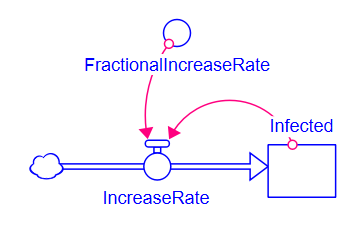

In [5]:
Image('Infection_model.png')

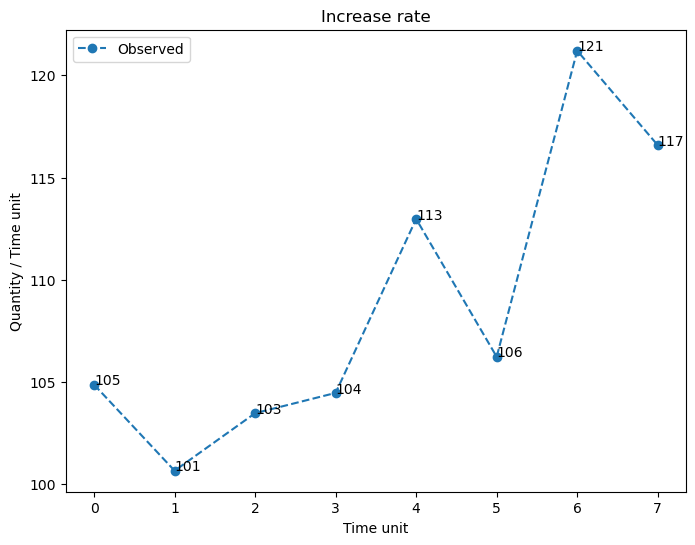

In [6]:
sim_time = 7
dt = 1

sd_model.simulate(time=sim_time, dt=dt)

df_sd_model = sd_model.export_simulation_result()

np.random.seed(1) # use a fixed random seed
observed_increase_rate_noised = np.random.normal(df_sd_model['IncreaseRate'], scale=3)

plot_time_series({'Increase rate': {'Observed': observed_increase_rate_noised}})

### Parameters to Estimate

| Parameter              | Range   | Unit         | Explanation                    |
| :--------------------  | :-----  | :-------     | :----------------------------- |
| FractionalIncreaseRate | [0-1]   | unitless/day | Daily fractional increase rate of case    |

### Markov Chain Monte Carlo - Estimating Posterior Probability of Parameters

#### Payoff function

Using Poisson distribution (Andrade and Duggan, 2020)

Explanation of using Poisson for likelihood function found at:
1. https://www.statlect.com/fundamentals-of-statistics/Poisson-distribution-maximum-likelihood
2. https://www.vensim.com/documentation/extended_payoffs.html

In [7]:
def payoff_function(params):

    # print('Likelihood function called: ', called_count)

    param = params[0]

    # simulate the sd model using parameters
    sd_model.clear_last_run()
    sd_model.replace_element_equation('FractionalIncreaseRate', param)
    # sd_model.simulate(simulation_time=sim_time, dt=dt)
    sd_model.simulate(time=sim_time, dt=dt)
    
    sim = sd_model.get_element_simulation_result('IncreaseRate')

    integral_payoff_over_simulation = 0

    if settings['payoff'] == 'Squared error':
        l_function = absolute_error_payoff_contribution
    elif settings['payoff'] == 'Poisson':
        l_function = poisson_log_likelihood_payoff_contribution
    else:
        print('Error: Payoff function not specified')
        return

    for t in range(int(sim_time/dt)):
        payoff_infected_t = l_function(observed_increase_rate_noised[t], sim[t], weight=1.0)
        integral_payoff_over_simulation += payoff_infected_t * dt

    # whole payoff function

    if settings['estimate'] == 'MLE':
        payoff = integral_payoff_over_simulation
    else:
        print('Error: Estimate method not specified')
        return

    # print('LL overall', log_posterior)
#     print(param, '\n',payoff, '\n')
    return payoff

#### PyMC3 model (the MCMC sampler)

In [8]:
ndraws = settings['ndraws']  # number of draws from the distribution
nburn = settings['nburn']  # number of "burn-in" points to discard

# create likelihood Op
# logl = LogLike(payoff_function)
logl = LogLikeWithGrad(payoff_function)

# use PyMC3 to sample from log-likelihood

with pm.Model() as model:
    # set priors on theta
    f_i_rate = pm.Uniform('f_i_rate', lower=0.01, upper=0.99)

    # theta = pt.as_tensor_variable(f_i_rate) # changed due to the change in PyMC backend
    theta = pt.as_tensor_variable([f_i_rate])

    # create custom distribution
    # don't use DensityDist - use Potential. see: https://github.com/pymc-devs/pymc3/issues/4057#issuecomment-675589228
    pm.Potential('likelihood', logl(theta))

    # use a sampling method
    if settings['step'] == 'Metropolis':
        step = pm.Metropolis()
    elif settings['step'] == 'Slice':
        step = pm.Slice()
    elif settings['step'] == 'NUTS':
        step = pm.NUTS()
    elif settings['step'] == 'HamiltonianMC':
        step = pm.HamiltonianMC()
    else:
        print('Warning: Sampling method not specified. Falling back.')

# use trace to collect all accepted samples
with model:
    trace = pm.sample(
        ndraws,
        tune=nburn,
        discard_tuned_samples=True,
        step=step,
        cores=settings['cores'],
        chains=settings['chains'],
        # return_inferencedata=False)
        return_inferencedata=True)

/Users/jonker/opt/anaconda3/envs/sdbn/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Only 200 samples in chain.
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [f_i_rate]


Sampling 8 chains for 700 tune and 200 draw iterations (5_600 + 1_600 draws total) took 5 seconds.


#### Visualise Model

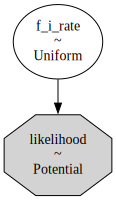

In [9]:
pm.model_to_graphviz(model)

#### Diagnostics

##### Trace plot

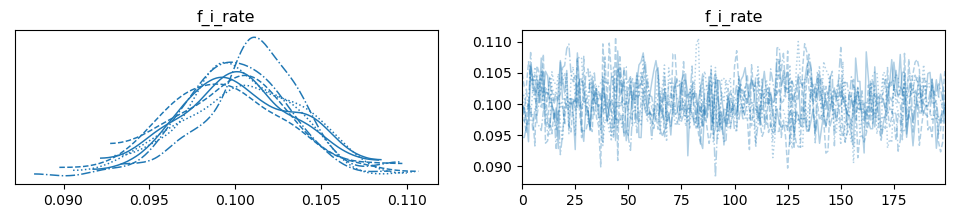

In [10]:
# az.plot_trace(trace, ['f_i_rate'])
_ = az.plot_trace(trace)

##### Autocorrplot

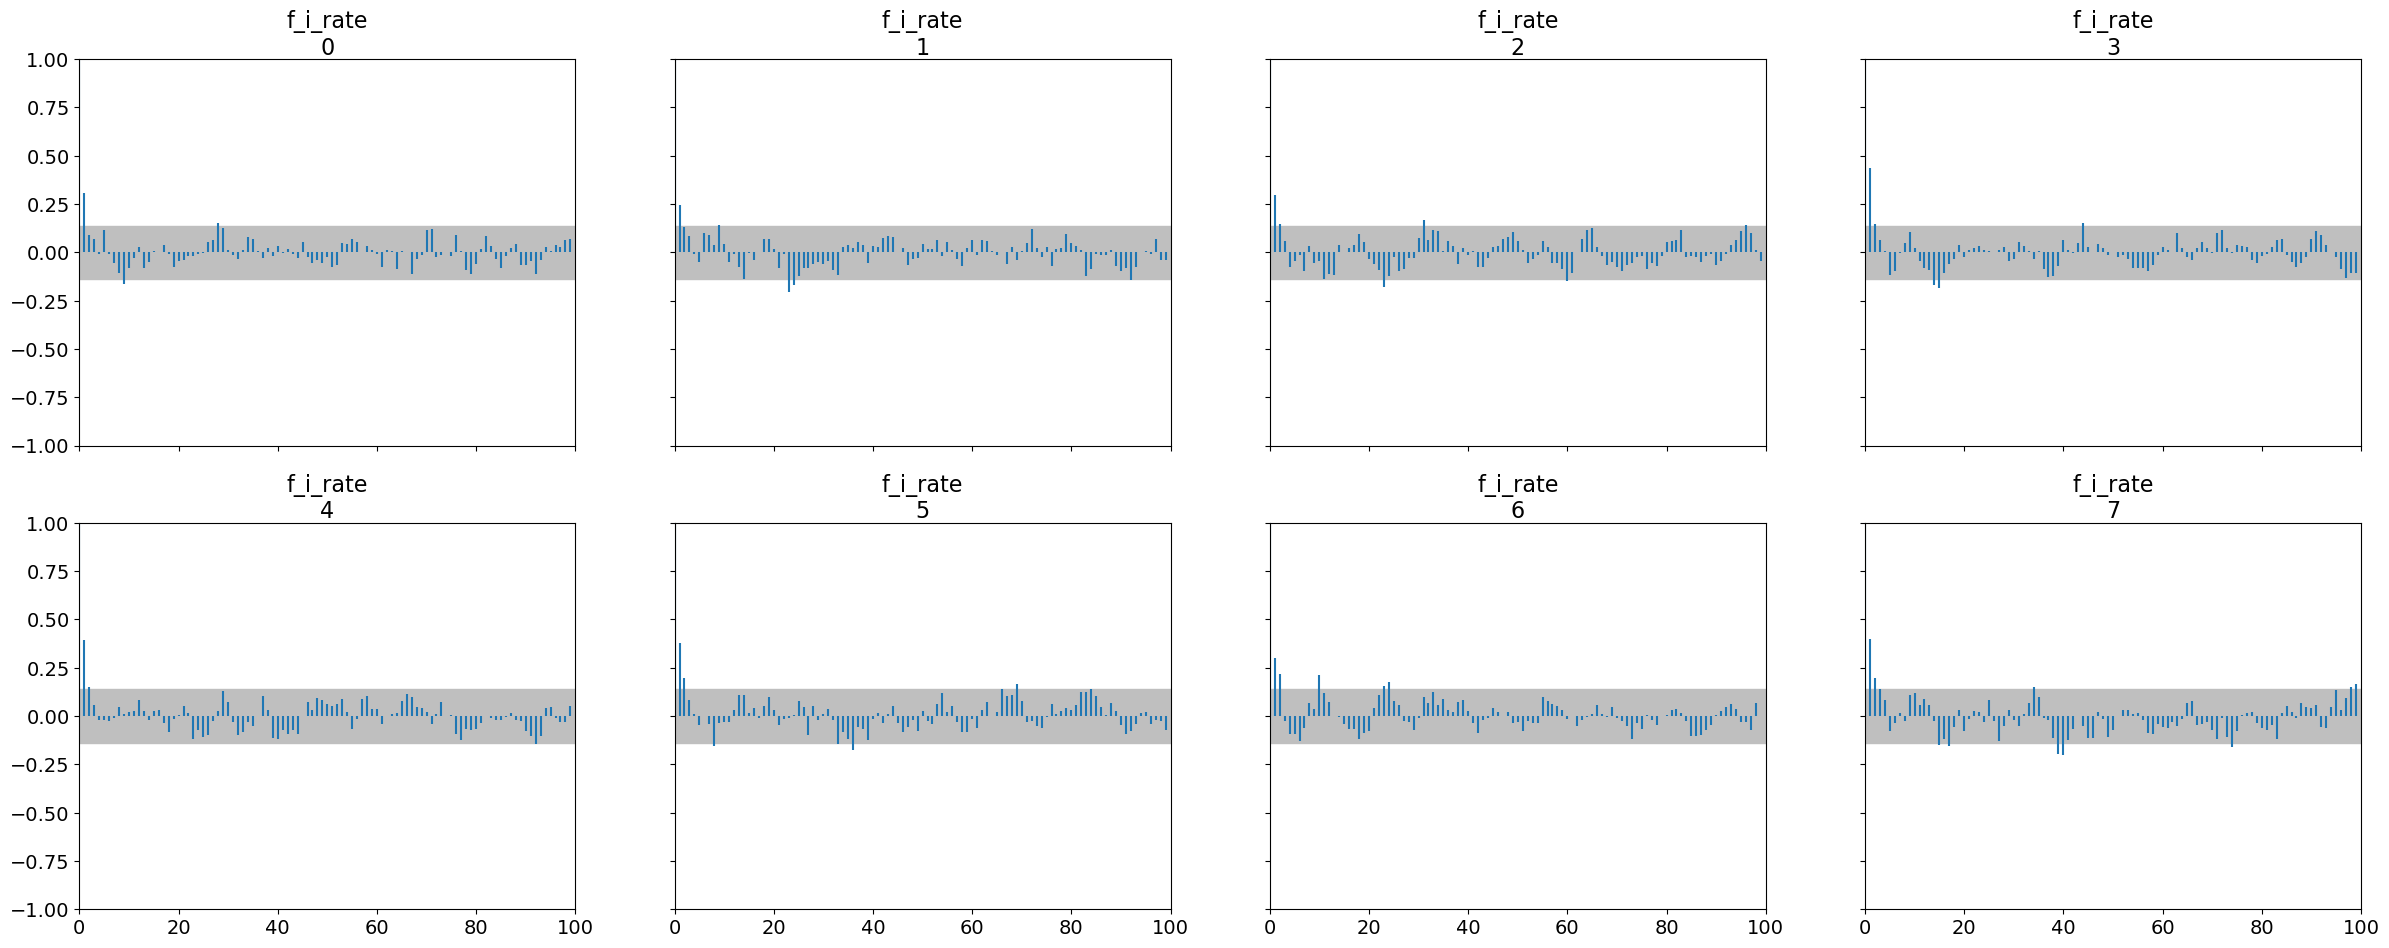

In [11]:
_ = az.plot_autocorr(trace, ['f_i_rate'])

### Estimation vs. Real data

#### Parameter value: estimate vs. ground truth

In [12]:
trace.posterior.data_vars['f_i_rate']

<xarray.DataArray 'f_i_rate' (chain: 8, draw: 200)>
array([[0.09954353, 0.09944211, 0.09752906, ..., 0.10479516, 0.10275239,
        0.09697859],
       [0.09856061, 0.09962862, 0.09669719, ..., 0.10061603, 0.09931967,
        0.09931967],
       [0.09744974, 0.09744974, 0.09534426, ..., 0.09233621, 0.09392275,
        0.1022577 ],
       ...,
       [0.10208722, 0.10118612, 0.09974058, ..., 0.09722989, 0.09722989,
        0.10003651],
       [0.10489919, 0.10281102, 0.1028656 , ..., 0.09580011, 0.10131213,
        0.10528687],
       [0.09999113, 0.09856599, 0.10237603, ..., 0.09697172, 0.09854604,
        0.09937674]])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199

In [13]:
np.mean(trace.posterior.data_vars['f_i_rate'].to_numpy())

0.10023966185535065

| Parameter              | Estimate  | Ground truth  |
| :--------------------  | :-------  | :--------     |
| FractionalIncreaseRate | 0.10019138579013617  | 0.1 |


#### Time series: synthetic vs. historical

0.10023966185535065


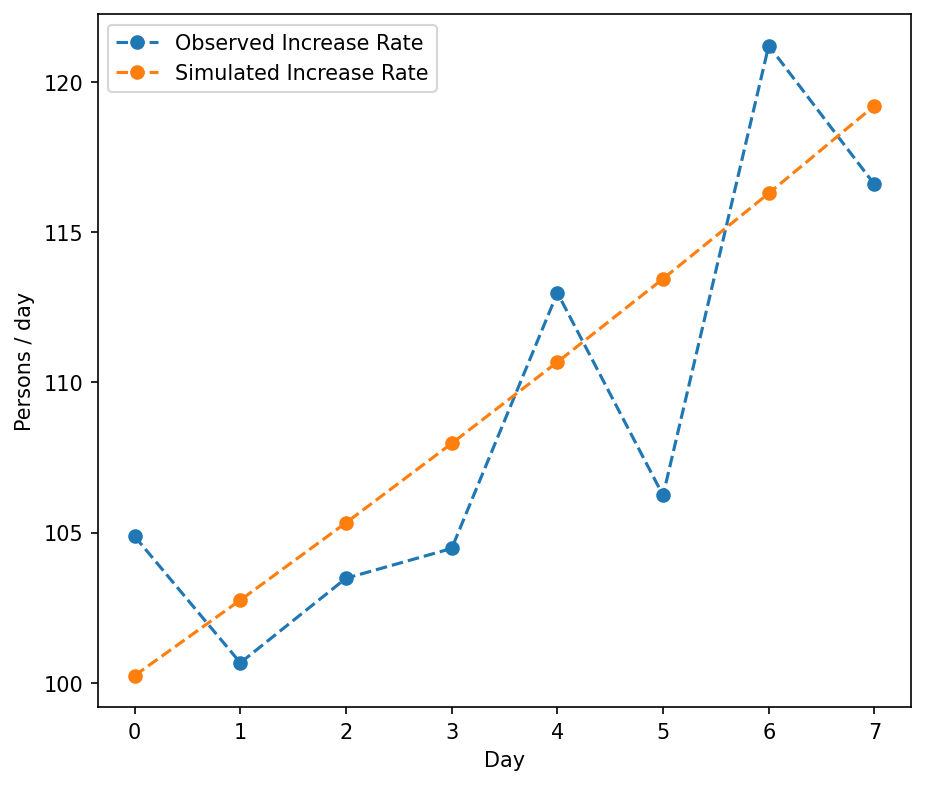

In [14]:
f_i_rate_est = np.mean(trace.posterior.data_vars['f_i_rate'].to_numpy())
print(f_i_rate_est)

sd_model.replace_element_equation('FractionalIncreaseRate', f_i_rate_est)
sd_model.clear_last_run()
# sd_model.simulate(simulation_time=sim_time, dt=dt)
sd_model.simulate(time=sim_time, dt=dt)
simulated_increase_rate_1 = sd_model.get_element_simulation_result('IncreaseRate')

fig = plt.figure(figsize=(7, 6),
                dpi=150)
ax = fig.add_subplot(111)

line1, = plt.plot(observed_increase_rate_noised, label='Observed Increase Rate', linestyle='--', marker='o')
# x1, y1 = line1.get_data()
# for i, j in zip(x1, y1):
#     ax.annotate(round(j), xy=(i,j))

line2, = plt.plot(simulated_increase_rate_1, label='Simulated Increase Rate', linestyle='--', marker='o')
# x2, y2 = line2.get_data()
# for i, j in zip(x2, y2):
#     ax.annotate(round(j), xy=(i,j))

plt.legend()
plt.xlabel('Day')
plt.ylabel('Persons / day')

plt.show()